<a href="https://colab.research.google.com/github/yaminsu5674/Style_Transfer_Project/blob/main/Style_Transfer_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os, cv2
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torchvision import transforms

from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter()


In [ ]:
test_kang= cv2.imread('/content/gdrive/MyDrive/kang_x2.png', cv2.IMREAD_COLOR)
test_kang= cv2.cvtColor(test_kang, cv2.COLOR_BGR2RGB)


(892, 1280, 3)


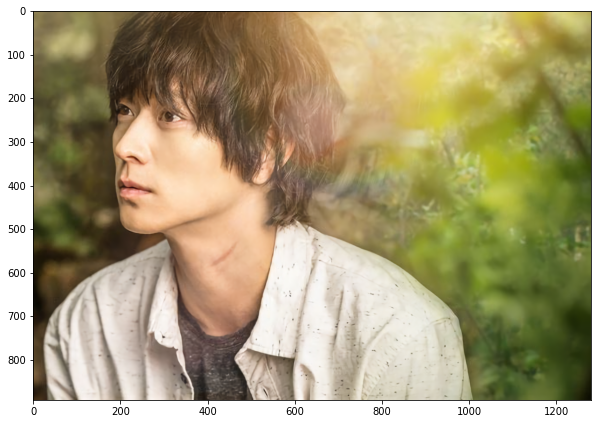

In [ ]:
print(test_kang.shape)
plt.figure(figsize= (10,10))
plt.imshow(test_kang)

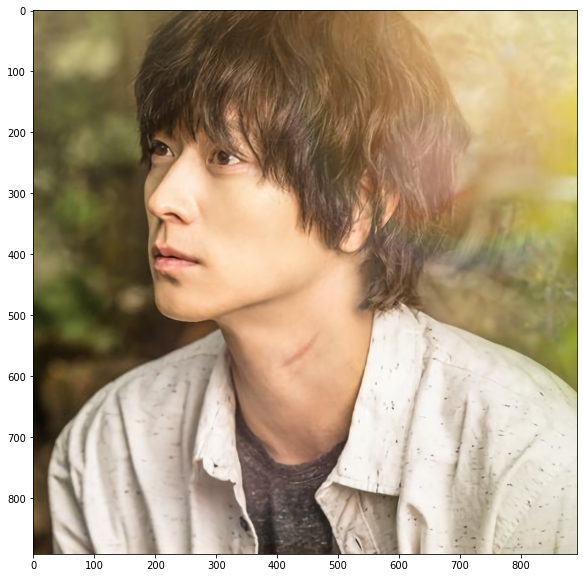

In [ ]:
test_kang= test_kang[:, :-(1280-892)]        # passive cropping this image needs
plt.figure(figsize= (10, 10))
plt.imshow(test_kang)

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device to use : ',device )

device to use :  cuda


In [ ]:
img_size= 512 if torch.cuda.is_available() else 128
print(img_size)

512


In [ ]:
img_transform= transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Resize((img_size, img_size))
])

In [ ]:
def image_loader(path):
  img= cv2.imread(path, cv2.IMREAD_COLOR)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img= img_transform(img).unsqueeze(0)
  return img.to(device, torch.float) 

In [ ]:
def image_loader_special(img):          # to load image that needs user's handled cropping procedure 
  img= img_transform(img).unsqueeze(0)
  return img.to(device, torch.float)

In [ ]:
style_img= image_loader('/content/gdrive/MyDrive/beauty_model.png')
#content_img= image_loader('/content/gdrive/MyDrive/test_stargan/han.jpg')
content_img= image_loader_special(test_kang)

print(style_img.shape, content_img.shape)

assert style_img.shape == content_img.shape, 'no matching images each other' 

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


In [ ]:
plt.ion()

def imshow(original_image, title=None):
  b, c, h, w= original_image.size()
  img= original_image.clone().cpu()
  img= img.squeeze(0)
  img= np.array(img)
  img= img.transpose(1,2,0)
  plt.figure(figsize= (8,8))
  if title:
    plt.title(title)
  plt.imshow(img)
  plt.pause(0.001)
  print


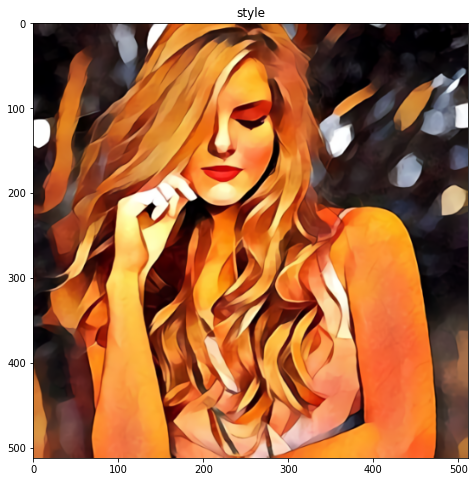

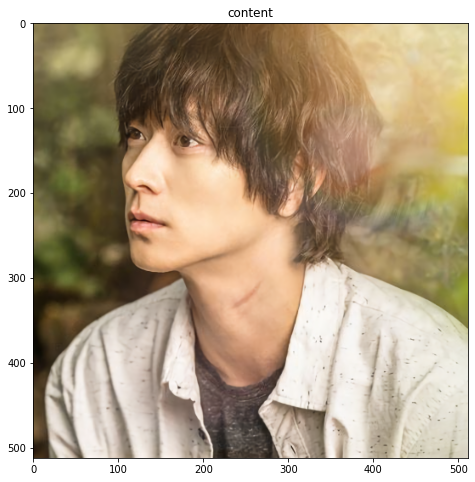

In [ ]:
imshow(style_img, 'style')
imshow(content_img, 'content')

In [ ]:
class Content_Loss(nn.Module):
  def __init__(self, target):
    super(Content_Loss, self).__init__()
    self.target= target.detach()

  def forward(self, input):
    self.loss= F.mse_loss(input, self.target)
    return input

In [ ]:
def GramMatrix(tensor):
  b, c, h, w= tensor.size()
  features= tensor.view(b * c, h * w)
  Gram= torch.mm(features, features.t())
  return Gram.div(b * c * h * w)


In [ ]:
class Style_Loss(nn.Module):
  def __init__(self, target):
    super(Style_Loss, self).__init__()
    self.target= target.detach()

  def forward(self, input):
    target_gram= GramMatrix(self.target)
    input_gram= GramMatrix(input)
    self.loss= F.mse_loss(input_gram, target_gram)
    return input


In [ ]:
cnn= models.vgg19_bn(pretrained= True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean= torch.tensor(mean).view(-1, 1, 1)
    self.std= torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    return (img- self.mean)/ self.std

In [ ]:
content_layers_default= ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
def get_model_losses(content_img, style_img, content_layers= content_layers_default,
                     style_layers= style_layers_default, cnn= cnn,
                     mean= cnn_normalization_mean, std= cnn_normalization_std):
  normalization= Normalization(mean, std).to(device)

  content_losses= []
  style_losses= []

  model= nn.Sequential(normalization)

  count= 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      count+= 1
      name= 'conv_{}'.format(count)
    elif isinstance(layer, nn.ReLU):
      name= 'relu_{}'.format(count)
      layer= nn.ReLU(inplace= False)
    elif isinstance(layer, nn.MaxPool2d):
      name= 'pool_{}'.format(count)
    elif isinstance(layer, nn.BatchNorm2d):
      name= 'bn_{}'.format(count)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = Content_Loss(target)
      model.add_module("content_loss_{}".format(count), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = Style_Loss(target_feature)
      model.add_module("style_loss_{}".format(count), style_loss)
      style_losses.append(style_loss)

  for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], Content_Loss) or isinstance(model[i], Style_Loss):
            break

  model = model[:(i + 1)]

  return model, style_losses, content_losses



In [ ]:
def get_Optimizer(train_img):
  optimizer= optim.LBFGS([train_img.requires_grad_()], lr=1)
  return optimizer

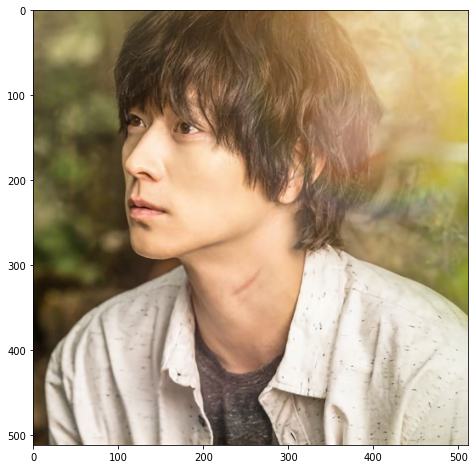

In [ ]:
#input_noise= Noise_Making(content_img)
input_noise= content_img.clone()
imshow(input_noise)

In [ ]:
def run_style_transfer(content_img, style_img, input_img,
                       mean= cnn_normalization_mean, std= cnn_normalization_std,
                       cnn= cnn, num_steps= 300,
                       style_weight= 1000000, content_weight= 1):
 
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_model_losses(content_img, style_img)
    optimizer = get_Optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

  


In [ ]:
output= run_style_transfer(content_img, style_img, input_noise)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


run [50]:
Style Loss : 2.152817 Content Loss: 0.121555

run [100]:
Style Loss : 0.050366 Content Loss: 0.110959

run [150]:
Style Loss : 0.018161 Content Loss: 0.085921

run [200]:
Style Loss : 0.012774 Content Loss: 0.072751

run [250]:
Style Loss : 0.011591 Content Loss: 0.063785

run [300]:
Style Loss : 0.010532 Content Loss: 0.058695



In [ ]:
def output_imshow(img):
  img= img.detach()
  imshow(img)

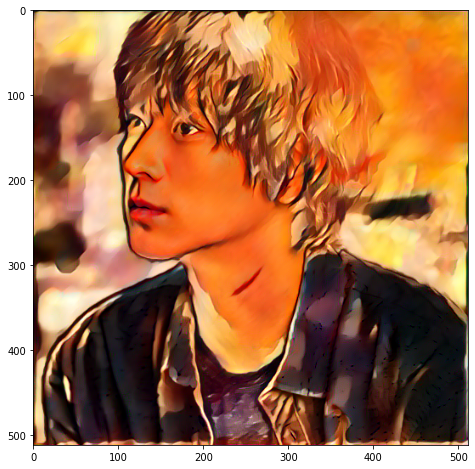

In [ ]:
output_imshow(output)

In [ ]:
def tensor2original(img):
  img= img.clone().detach().cpu()
  img= img.squeeze(0)
  img= np.array(img).transpose(1,2,0)
  img*= 255
  img= img.astype(np.uint8)
  return img


In [ ]:
def save_the_output(tensor):
  img= tensor2original(tensor)
  img= cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  cv2.imwrite('saved_img_style_transfered.jpg', img)
  print('Output is downloaded!')

Below is the comprehensive class that I made using upper classes and functions for the convenient precedure that makes the user feel making transfer style image easy.

In [ ]:
class Style_Transfer(nn.Module):
  def __init__(self, content_path, style_path, check1= None, check2= None):
    super(Style_Transfer, self).__init__()
    #------------ init settings
    if check1:
      self.content_img= image_loader_special(content_path)
    else:
      self.content_img= image_loader(content_path)
    if check2:
      self.style_img= image_loader_special(style_path)
    else:
      self.style_img= image_loader(style_path)

    assert self.style_img.shape == self.content_img.shape, 'no matching images each other'

    self.input= self.content_img.clone() 
    self.model, self.content_losses, self.style_losses= get_model_losses(content_img= self.content_img, style_img= self.style_img)

    #------------ mechanisms of algorithm and show the processs
    
    print('images for Style Transferring')
    imshow(self.content_img, 'content')
    imshow(self.style_img, 'style')

    self.output= run_style_transfer(self.content_img, self.style_img, self.input)
    print('Training is done!!')
    print('-----------------------------')
    output_imshow(self.output)
    
  def save_output(self):
    save_the_output(self.output)
    print('downloaded successfully!')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


images for Style Transferring


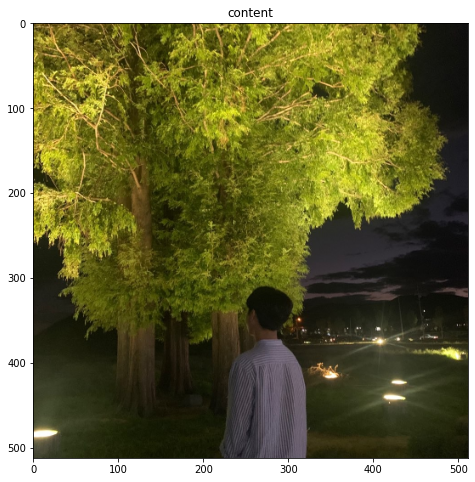

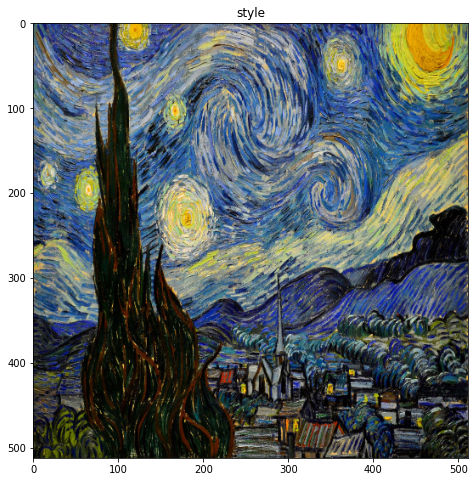

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.016940 Content Loss: 0.073139

run [100]:
Style Loss : 0.008563 Content Loss: 0.062723

run [150]:
Style Loss : 0.008263 Content Loss: 0.058496

run [200]:
Style Loss : 0.021349 Content Loss: 0.057291

run [250]:
Style Loss : 0.008534 Content Loss: 0.057794

run [300]:
Style Loss : 0.011061 Content Loss: 0.069555

Training is done!!
-----------------------------


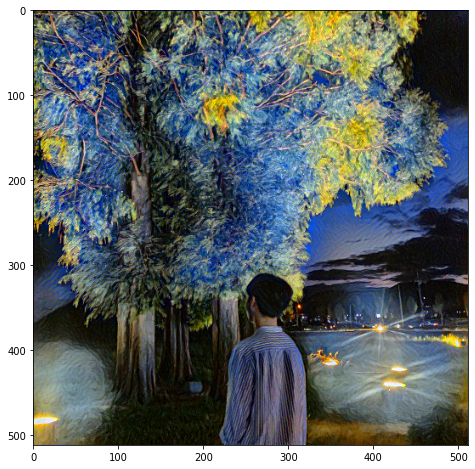

In [ ]:
new_kakao_profile= Style_Transfer('/content/gdrive/MyDrive/gogh.jpg', '/content/gdrive/MyDrive/starry_night3.jpg')

In [ ]:
new_kakao_profile.save_output()

Output is downloaded!
downloaded successfully!
